In [1]:
# @title: imports, and graphics setup
import sys
sys.path.append('..')
from multiprocessing import Pool, TimeoutError
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import numpy as np
import mpmath as mp
import scipy.stats as stats
import scipy.ndimage as ndimage
from scipy.optimize import curve_fit
from scipy import integrate as integrate
from Modules.potential_operations import histogram_potential_fitter, normalized_pdf_from_potential, generate_theoretical_pdf_for_fit
from Modules.custom_simulations import simulate_particles_in_external_force_Not_HOOMD
import warnings
from scipy.optimize import fsolve
from tqdm.auto import tqdm, trange
from Modules.pdfs import *
from joblib import Parallel, delayed
import re

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

In [2]:
from Modules.potentials import harmonic_potential
from Modules.forces import harmonic_force

In [3]:
def run_simulation(n_particles, steps, x_start_position, force ,force_args, delta_fraction,dt, kT, gamma):
    start_position=x_start_position
    args = [force, n_particles, steps, delta_fraction]
    trajectories = simulate_particles_in_external_force_Not_HOOMD(*args, dt=dt, kT=kT, force_args=force_args, start_position=start_position, gamma=gamma, type=np.float32)
    x_positions = np.array(trajectories)
    return x_positions

In [4]:
def resample_trajectories(trajectories, n_resamples, seed):
    rng = np.random.default_rng(seed) # reproducible results
    N = trajectories.shape[1]
    idx = rng.integers(N, size=n_resamples)     # vectorized draw
    return np.take(trajectories, idx, axis=1)

In [4]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 100000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
typical_length_scale = np.sqrt(kT/k_harm)

### a lot of starting positions (for speedup vs. Xr) ###
### log spacing ###
'''
start_position_ratios_small = np.linspace(0, 1, 6)
start_position_ratios_high = np.linspace(1, 3, 9)[1:]
start_position_ratios = np.concatenate((start_position_ratios_small, start_position_ratios_high))
'''
### linear spacing ###
'''
start_position_ratios_small = np.linspace(0, 2, 11)
start_position_ratios_high = np.linspace(2, 5, 4)[1:]
start_position_ratios = np.concatenate((start_position_ratios_small, start_position_ratios_high))
print('start_position_ratios:', start_position_ratios)
start_positions = -start_position_ratios * typical_length_scale
start_positions_str = [f'{pos:.3f}'[1:] for pos in start_positions]
start_positions_str = ','.join(start_positions_str)
print('start_positions:', start_positions)
'''

### a few starting positions (for speed up vs. S) ###
start_positions_sigmas = np.array([0, 0.3, 1, 3])
start_positions = -start_positions_sigmas * typical_length_scale
start_positions_str = [f'{pos:.3f}'[1:] for pos in start_positions]
start_positions_str = ','.join(start_positions_str)
print('start_positions:', start_positions)

### resetting parameters ### 

### for log spacing speedup vs. S ###
#delta_fractions = k_harm*np.logspace(np.log10(0.00002), np.log10(0.030), 15)/5

### for linear spacing speedup vs. S ###
S_ratios = np.concatenate((np.linspace(0, 2, 11), np.linspace(2, 5, 4)[1:]))
print('S_ratios:', S_ratios)
delta_fractions = (k_harm*S_ratios/gamma)*dt

### for speedup vs. Xr - a few S values ###
'''
delta_fractions = k_harm*np.array([0.0005,0.002,0.01])/5
delta_fractions_to_add = np.array([0])
delta_fractions = np.concatenate((delta_fractions_to_add, delta_fractions))
'''

colors = cm.rainbow(np.linspace(0, 1, len(delta_fractions)))
resetting_rates = delta_fractions/dt

sherf_nums = gamma*resetting_rates/k_harm
print('Sherf numbers:', sherf_nums)

resetting_rates_str = [f'{rate:.2f}'[1:] for rate in resetting_rates]
resetting_rates_str = ','.join(resetting_rates_str)
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
if k_harm != 5:
    folder += f'_k={k_harm}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
print('Folder -', folder)
print('Subfolders -', subfolders)

start_positions: [-0.         -0.13416408 -0.4472136  -1.34164079]
S_ratios: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  3.  4.  5. ]
Sherf numbers: [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  3.  4.  5. ]
Folder - HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342
Subfolders - ['HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.000', 'HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.134', 'HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.447', 'HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--1.342']


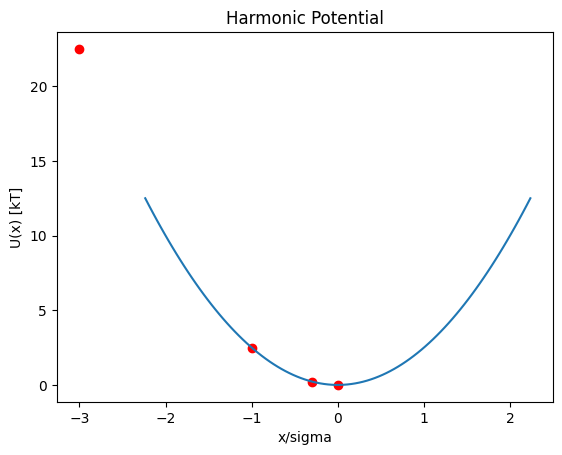

In [10]:
### plot potential ###
potential_x_unnormalized = np.linspace(-1, 1, 100)
potential_y_unnormalized = harmonic_potential(potential_x_unnormalized, k_harm)
potential_x = np.linspace(-1, 1, 100)/typical_length_scale
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y)
plt.scatter(start_positions/typical_length_scale, harmonic_potential(start_positions/typical_length_scale, k_harm)/kT, color='red', label='Start Positions')
plt.xlabel('x/sigma')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

In [47]:
#raise KeyboardInterrupt
### Run simulations ###
os.makedirs(folder, exist_ok=True)
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
if __name__ == "__main__":
    for start_position, subfolder in zip(start_positions, subfolders):
        os.makedirs(subfolder, exist_ok=True)
        print('Subfolder:', subfolder)
        filenames = os.listdir(subfolder)
        existing_batches = 0
        for file in filenames:
            if re.search("^batch.*npy", file):
                nums = re.findall((r'\d+'), file)
                n = ''.join(nums)
                if int(n) > existing_batches:
                    existing_batches = int(n)
        print("Existing Batches: ", existing_batches)
        for _ in np.arange(0 , n_particles, batch_size):
            simulation_parameters = [(batch_size, steps, start_position, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for delta_fraction in delta_fractions]
            trajectories_per_rate = Parallel(n_jobs=-1, verbose = 0, backend='loky')(delayed(run_simulation)(*args) for args in simulation_parameters)
            np.save(subfolder+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_rate)
            print(f'Finished {_+batch_size} particles')
    print('Finished all particles')

[0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]
Subfolder: HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.000
Existing Batches:  10
Finished 10000 particles
Finished 20000 particles
Finished 30000 particles
Finished 40000 particles
Finished 50000 particles
Finished 60000 particles
Finished 70000 particles
Finished 80000 particles
Finished 90000 particles
Finished 100000 particles
Subfolder: HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,1.342/X--0.134
Existing Batches:  10
Finished 10000 particles
Finished 20000 particles
Finished 30000 particles
Finished 40000 particles
Finished 50000 particles
Finished 60000 particles
Finished 70000 particles
Finished 80000 particles
Finished 90000 particles
Finished 100000 particles
Subfolder: HarmonicPotentialTrajectories/R-.00,.00,.00,.01,.01,.01,.01,.01,.02,.02,.02,.03,.04,.05_X-0.000,0.134,0.447,

In [21]:
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
if k_harm != 5:
    folder += f'_k={k_harm}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
filenames = os.listdir(subfolders[0])
trajectories = np.load(subfolders[0] + '/' + filenames[0], allow_pickle=True)
trajectories_per_rate_per_start = np.array(trajectories)

In [110]:
del trajectories
del trajectories_per_rate_per_start

In [103]:
a = resample_trajectories(trajectories_per_rate_per_start[0], 100000, seed=None)
print(a.shape)

(10000, 100000)


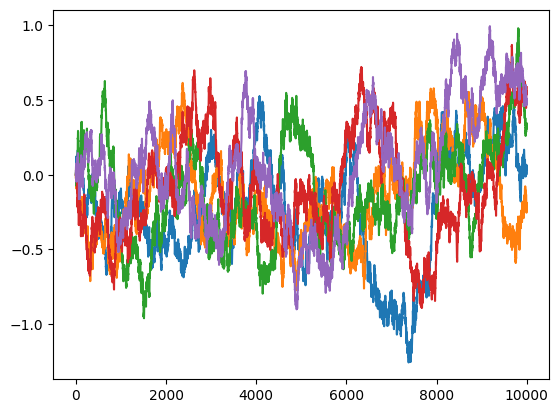

In [105]:
plt.plot(a[:, 50000:50005])
#plt.xlim(0,1000)
plt.show()

In [ ]:
print(trajectories_per_rate_per_start.shape)

(14, 10000, 10000)


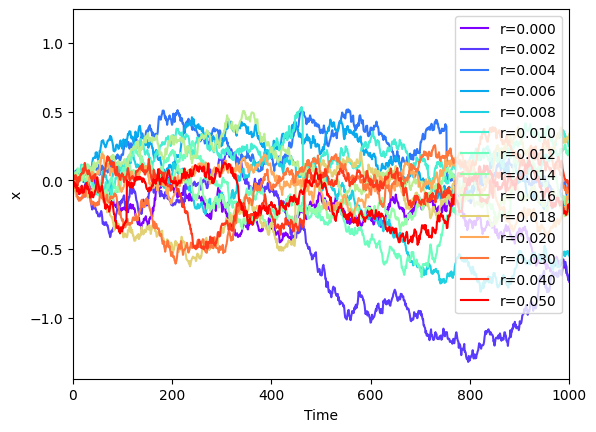

In [75]:
### plot trajectories ###
for i, [rate, trajs] in enumerate(zip(resetting_rates, trajectories_per_rate_per_start)):
    plt.plot(np.arange(steps), trajs[:, 0], label=f'r={rate:.3f}', color=colors[i])
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.xlim(0, 1000)
plt.show()

In [107]:
def _calculate_single_mean_var(x_pos):
    mean = np.mean(x_pos, axis=1)
    var = np.var(x_pos, axis=1)
    return mean, var

def calculate_mean_var_trajectory_per_rate(trajs):
    # Using parallel processing for each trajectory
    #means_vars_per_pos = Parallel(n_jobs=-1, prefer='threads')(
    #    delayed(_calculate_single_mean_var)(x_pos) for x_pos in trajs
    #)
    ### not parallel version
    means_vars_per_pos = []
    for x_pos in trajs:
        means_vars_per_pos.append(_calculate_single_mean_var(x_pos))
    return np.array(means_vars_per_pos)

def _calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples, n_resamples=None):
    histograms_per_timestep = []
    if n_resamples is not None:
        x_pos = resample_trajectories(x_pos, n_resamples, seed=None)
    target_distribution_points = x_pos[-n_target_distribution_samples:]
    target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
    for timestep in timesteps:
        if timestep != 0:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
        else:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histograms_per_timestep.append([histogram, bin_centers])
    histograms_per_timestep.append([target_distribution, bin_centers])
    del x_pos
    return histograms_per_timestep

def generate_histograms_per_rate(trajs, bins, timesteps, n_samples, n_target_distribution_samples, n_resamples=None):
    histograms_per_rate = []
    histograms_per_rate = Parallel(n_jobs=-1, prefer='threads')(delayed(_calculate_single_histogram)(x_pos, bins, timesteps, n_samples, n_target_distribution_samples, n_resamples=n_resamples) for x_pos in trajs)
    '''
    for x_pos in trajs:
        histograms_per_rate.append(_calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples))
    histograms_per_rate = np.array(histograms_per_rate)
    '''
    return histograms_per_rate

def calculate_average_measure_per_batches(folder, measure, batches=-1, args=[]):
    if batches == 0:
        return None
    c = 0
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                value = measure(trajectories_per_r, *args)
            else:
                value += measure(trajectories_per_r, *args)
            c+=1
            if batches != -1 and batches == c:
                break
            del trajectories_per_r
            if batches == -1:
                print(f'finished batch {c}')
            else:
                print(f'finished batch {c} of {batches}')
            if batches != -1 and batches == c:
                break
    if measure != generate_histograms_per_rate:
        final_value = value/c
    else:
        final_value = np.array(value)
        final_value[:,0] = final_value[:,0]/c
    return final_value

In [6]:
resetting_colors = cm.rainbow(np.linspace(0, 1, len(resetting_rates)))

##### moments analysis

In [9]:
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}'
if k_harm != 5:
    folder += f'_k={k_harm}'
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]

for subfolder in tqdm(subfolders):
    means_vars = calculate_average_measure_per_batches(subfolder, calculate_mean_var_trajectory_per_rate, batches=3)
    means = means_vars[:, 0]
    vars = means_vars[:, 1]
    third_moments = means_vars[:, 2]
    fourth_moments = means_vars[:, 3]
    np.save(subfolder+'/mean_trajectories.npy', means)
    np.save(subfolder+'/var_trajectories.npy', vars)
    np.save(subfolder+'/third_moment_trajectories.npy', third_moments)
    np.save(subfolder+'/fourth_moment_trajectories.npy', fourth_moments)

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
### load means and variances per start position ###
means_per_start = []
vars_per_start = []
third_moments_per_start = []
fourth_moments_per_start = []
for subfolder in subfolders:
    means = np.load(subfolder+'/mean_trajectories.npy')
    vars = np.load(subfolder+'/var_trajectories.npy')
    third_moments = np.load(subfolder+'/third_moment_trajectories.npy')
    fourth_moments = np.load(subfolder+'/fourth_moment_trajectories.npy')
    means_per_start.append(means)
    vars_per_start.append(vars)
    third_moments_per_start.append(third_moments)
    fourth_moments_per_start.append(fourth_moments)
means_per_start = np.array(means_per_start)
vars_per_start = np.array(vars_per_start)
third_moments_per_start = np.array(third_moments_per_start)
fourth_moments_per_start = np.array(fourth_moments_per_start)

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_11780\2204465582.py:12: SyntaxWarning: invalid escape sequence '\s'
  axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')


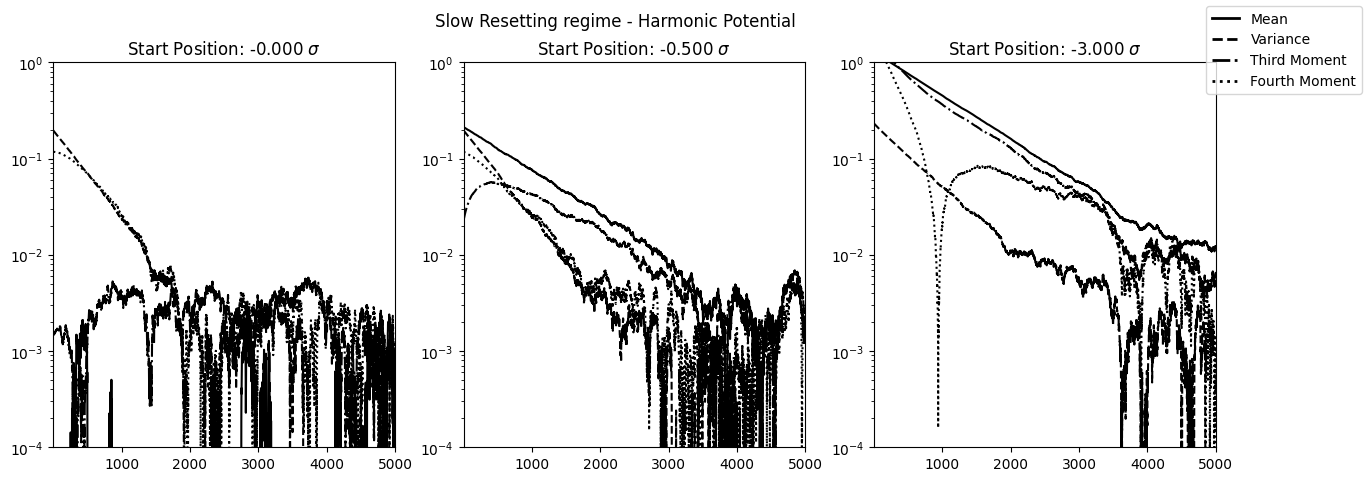

In [35]:
r=1
s = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(start_positions)):
    axes[i].plot(means_per_start[i][r][-1] - means_per_start[i][r], color='black')
    axes[i].plot(vars_per_start[i][r][-1] - vars_per_start[i][r], color='black', linestyle='--')
    axes[i].plot(abs(third_moments_per_start[i][r][-1] - third_moments_per_start[i][r]), color='black', linestyle='-.')
    axes[i].plot(abs(fourth_moments_per_start[i][r][-1] - fourth_moments_per_start[i][r]), color='black', linestyle=':')
    axes[i].set_xlim(0.01, 5000)
    axes[i].set_ylim(0.0001, 1)
    axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')
    #axes[i].set_xscale('log')
    axes[i].set_yscale('log')
fig.suptitle('Slow Resetting regime - Harmonic Potential')
mean_handle = axes[0].plot([], color='black', label='Mean', linewidth=2)
var_handle = axes[0].plot([], color='black', linestyle='--', label='Variance', linewidth=2)
third_moment_handle = axes[0].plot([], color='black', linestyle='-.', label='Third Moment', linewidth=2)
fourth_moment_handle = axes[0].plot([], color='black', linestyle=':', label='Fourth Moment', linewidth=2)
handles = [mean_handle[0], var_handle[0], third_moment_handle[0], fourth_moment_handle[0]]
fig.legend(handles=handles, loc='upper right')
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_11780\2797717759.py:12: SyntaxWarning: invalid escape sequence '\s'
  axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')


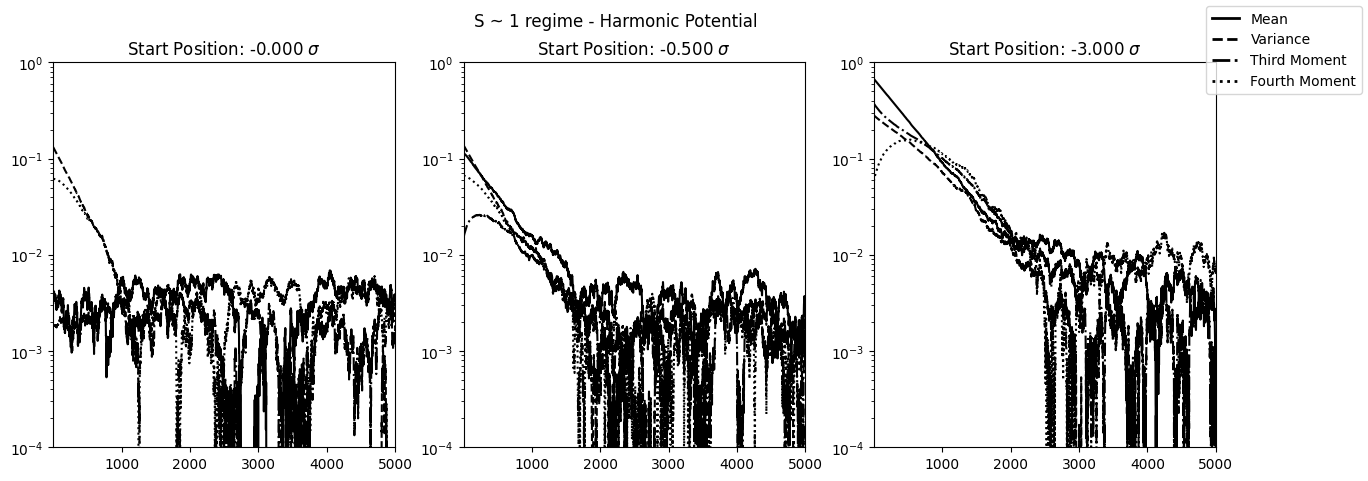

In [38]:
r=4
s = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(start_positions)):
    axes[i].plot(means_per_start[i][r][-1] - means_per_start[i][r], color='black')
    axes[i].plot(vars_per_start[i][r][-1] - vars_per_start[i][r], color='black', linestyle='--')
    axes[i].plot(abs(third_moments_per_start[i][r][-1] - third_moments_per_start[i][r]), color='black', linestyle='-.')
    axes[i].plot(abs(fourth_moments_per_start[i][r][-1] - fourth_moments_per_start[i][r]), color='black', linestyle=':')
    axes[i].set_xlim(0.01, 5000)
    axes[i].set_ylim(0.0001, 1)
    axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')
    #axes[i].set_xscale('log')
    axes[i].set_yscale('log')
fig.suptitle('S ~ 1 regime - Harmonic Potential')
mean_handle = axes[0].plot([], color='black', label='Mean', linewidth=2)
var_handle = axes[0].plot([], color='black', linestyle='--', label='Variance', linewidth=2)
third_moment_handle = axes[0].plot([], color='black', linestyle='-.', label='Third Moment', linewidth=2)
fourth_moment_handle = axes[0].plot([], color='black', linestyle=':', label='Fourth Moment', linewidth=2)
handles = [mean_handle[0], var_handle[0], third_moment_handle[0], fourth_moment_handle[0]]
fig.legend(handles=handles, loc='upper right')
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_11780\3388681680.py:12: SyntaxWarning: invalid escape sequence '\s'
  axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')


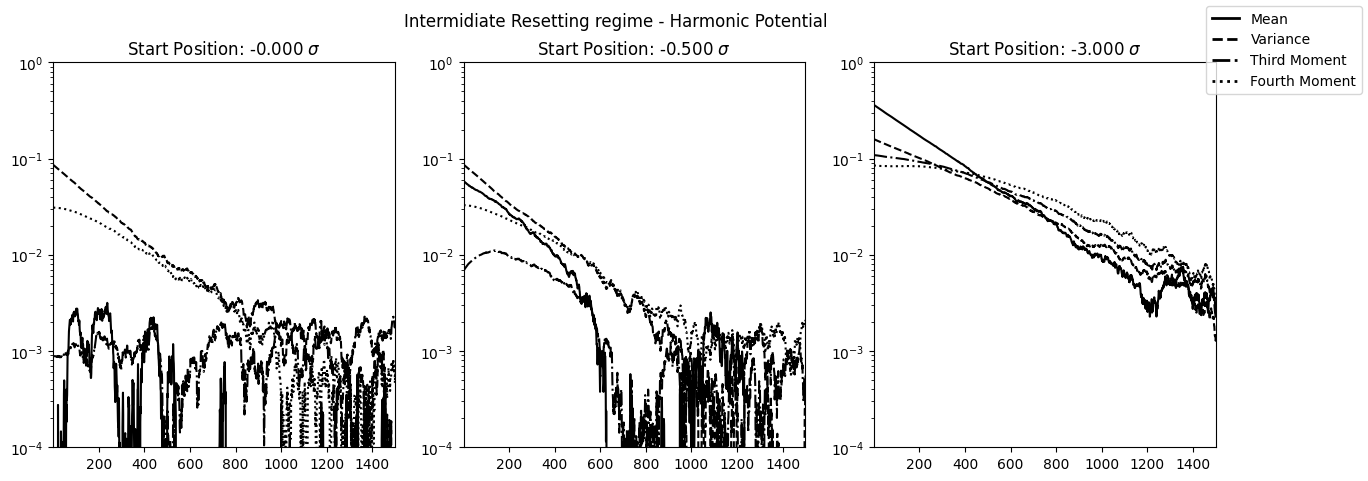

In [36]:
r= 9
s = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(start_positions)):
    axes[i].plot(means_per_start[i][r][-1] - means_per_start[i][r], color='black')
    axes[i].plot(vars_per_start[i][r][-1] - vars_per_start[i][r], color='black', linestyle='--')
    axes[i].plot(abs(third_moments_per_start[i][r][-1] - third_moments_per_start[i][r]), color='black', linestyle='-.')
    axes[i].plot(abs(fourth_moments_per_start[i][r][-1] - fourth_moments_per_start[i][r]), color='black', linestyle=':')
    axes[i].set_xlim(0.01, 1500)
    axes[i].set_ylim(0.0001, 1)
    axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')
    #axes[i].set_xscale('log')
    axes[i].set_yscale('log')
fig.suptitle('Intermidiate Resetting regime - Harmonic Potential')
mean_handle = axes[0].plot([], color='black', label='Mean', linewidth=2)
var_handle = axes[0].plot([], color='black', linestyle='--', label='Variance', linewidth=2)
third_moment_handle = axes[0].plot([], color='black', linestyle='-.', label='Third Moment', linewidth=2)
fourth_moment_handle = axes[0].plot([], color='black', linestyle=':', label='Fourth Moment', linewidth=2)
handles = [mean_handle[0], var_handle[0], third_moment_handle[0], fourth_moment_handle[0]]
fig.legend(handles=handles, loc='upper right')
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_11780\1279567276.py:12: SyntaxWarning: invalid escape sequence '\s'
  axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')


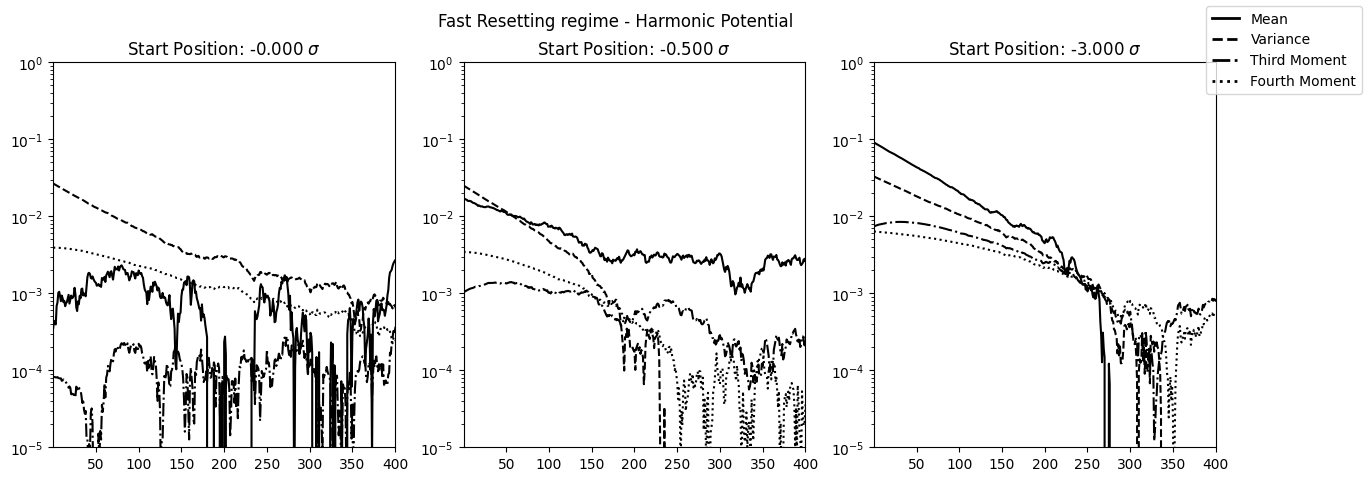

In [37]:
r=17
s = 0
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(start_positions)):
    axes[i].plot(means_per_start[i][r][-1] - means_per_start[i][r], color='black')
    axes[i].plot(vars_per_start[i][r][-1] - vars_per_start[i][r], color='black', linestyle='--')
    axes[i].plot(abs(third_moments_per_start[i][r][-1] - third_moments_per_start[i][r]), color='black', linestyle='-.')
    axes[i].plot(abs(fourth_moments_per_start[i][r][-1] - fourth_moments_per_start[i][r]), color='black', linestyle=':')
    axes[i].set_xlim(0.01, 400)
    axes[i].set_ylim(0.00001, 1)
    axes[i].set_title(f'Start Position: {start_positions[i]/typical_length_scale:.3f} $\sigma$')
    #axes[i].set_xscale('log')
    axes[i].set_yscale('log')
fig.suptitle('Fast Resetting regime - Harmonic Potential')
mean_handle = axes[0].plot([], color='black', label='Mean', linewidth=2)
var_handle = axes[0].plot([], color='black', linestyle='--', label='Variance', linewidth=2)
third_moment_handle = axes[0].plot([], color='black', linestyle='-.', label='Third Moment', linewidth=2)
fourth_moment_handle = axes[0].plot([], color='black', linestyle=':', label='Fourth Moment', linewidth=2)
handles = [mean_handle[0], var_handle[0], third_moment_handle[0], fourth_moment_handle[0]]
fig.legend(handles=handles, loc='upper right')
plt.show()

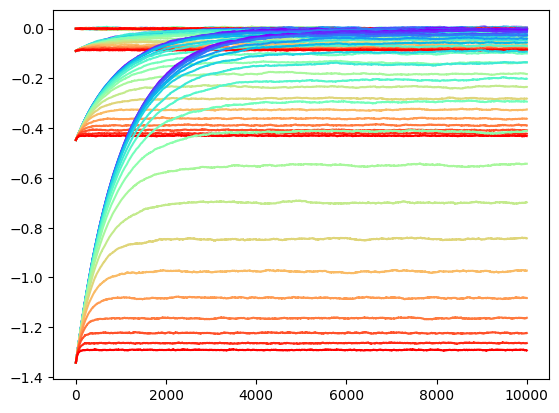

In [12]:
### plot mean per r ### 
for means, start_position in zip(means_per_start, start_positions):
    for c,mean_traj in zip(resetting_colors,means):
        plt.plot(mean_traj, color=c)
plt.show()

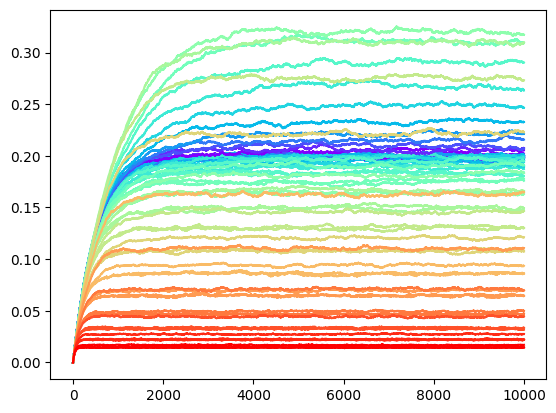

In [13]:
### plot vars per start ### 
for vars, start_position in zip(vars_per_start, start_positions):
    for c,vars_traj in zip(resetting_colors,vars):
        plt.plot(vars_traj, color=c)
plt.show()

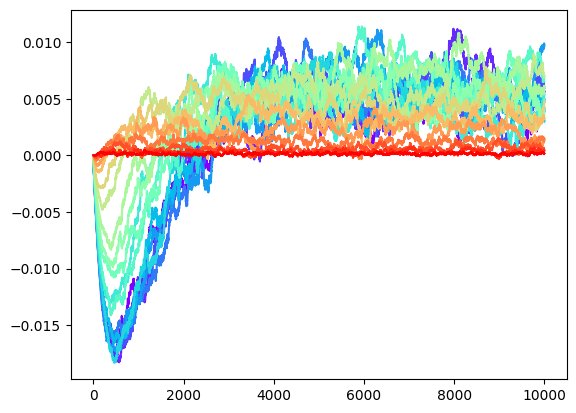

In [14]:
### plot vars per start ### 
co = 0
for third_moments, start_position in zip(third_moments_per_start, start_positions):
    if co == 1:
        for c,third_moment in zip(resetting_colors,third_moments):
            plt.plot(third_moment, color=c)
    co += 1
plt.show()

##### PDF animations

MovieWriter ffmpeg unavailable; using Pillow instead.


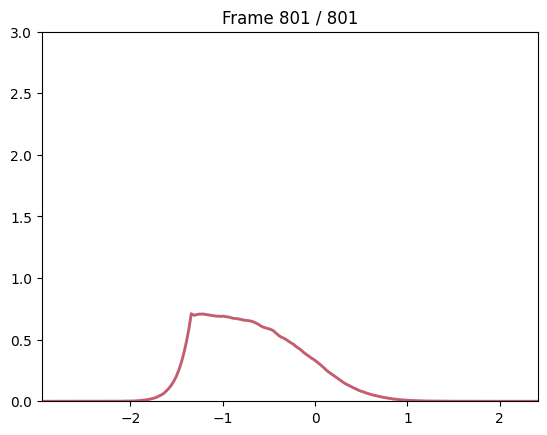

In [81]:
from matplotlib.animation import FuncAnimation

# Load bins_per_start_pos and subfolders
bins_per_start_pos = np.load(folder + '/bins_per_start_pos.npy', allow_pickle=True)

# Set up the figure
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2, alpha=0.5)
line2, = ax.plot([], [], lw=2, alpha=0.5, color='red')
#vline_mean = ax.axvline(0, color='black', linestyle='--', label='Mean')  # initialized but invisible
#vline_ss = ax.axvline(0, color='red', linestyle='--', label='Steady State Mean')

# Select subfolder and load histogram data
c = 0
for bins, subfolder in zip(bins_per_start_pos, subfolders):
    if c == 2:
        histograms_per_rate = np.load(subfolder + '/histograms_per_rate.npy', allow_pickle=True)
        #means_per_rate = np.load(subfolder + '/mean_trajectories.npy', allow_pickle=True)
    c += 1


histograms = histograms_per_rate[8]
#means = means_per_rate[4]
#mean_per_timestep = means[np.arange(0, 8000, 10)]

# Initialize function for animation
def init():
    line.set_data([], [])
    return line,

# Animation update function
def update(i):
    hist, bin = histograms[i, 0], histograms[i, 1]
    hist_ss, bin_ss = histograms[-1, 0], histograms[-1, 1]
    #mean = mean_per_timestep[i]
    #mean_ss = mean_per_timestep[-1]
    line.set_data(bin, hist)
    line2.set_data(bin_ss, hist_ss) 
    #vline_mean.set_xdata([mean, mean])
    #vline_ss.set_xdata([mean_ss, mean_ss])
    ax.set_xlim(np.min(bin), np.max(bin))
    ax.set_ylim(0, 3)  # Small buffer above max
    ax.set_title(f"Frame {i+1} / {len(histograms)}")
    return line, line2,# vline_mean, vline_ss,

# Create animation
ani = FuncAnimation(fig, update, frames=len(histograms), init_func=init, blit=True, interval=200)

# Optional: save to file
ani.save("histogram_animation_xsigma_3_more_not_so_very_small_s2.gif", writer="ffmpeg")

plt.show()


##### pdf analysis

In [108]:
samples = 5
target_distribution_samples = 500
steady_state = 8000
timesteps = np.arange(0, steady_state, 5)

In [17]:
bins_per_start_pos = []
for subfolder in tqdm(subfolders):
    filenames = os.listdir(subfolder)
    for filename in filenames:
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories = np.load(subfolder+'/'+filename, allow_pickle=True)
            bin_edges = np.histogram_bin_edges(trajectories[-1][-target_distribution_samples:], bins=201)
            bins_min = bin_edges[0]
            bin_edges = np.histogram_bin_edges(trajectories[0][-target_distribution_samples:], bins=201)
            bins_max = bin_edges[-1]
            bins = np.linspace(bins_min*1.5, bins_max*1.5, 201)
            bins_per_start_pos.append(bins)
            break
bins_per_start_pos = np.array(bins_per_start_pos)
np.save(folder+'/bins_per_start_pos.npy', bins_per_start_pos)    


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
bins_per_start_pos = np.load(folder+'/bins_per_start_pos.npy', allow_pickle=True)
for subfolder, bins in tqdm(zip(subfolders, bins_per_start_pos)):
    args = [bins, timesteps, samples, target_distribution_samples]
    histograms_per_rate = calculate_average_measure_per_batches(subfolder, generate_histograms_per_rate, args=args, batches=-1)
    np.save(subfolder+'/histograms_per_rate.npy', histograms_per_rate)

0it [00:00, ?it/s]

finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
finished batch 16
finished batch 17
finished batch 18
finished batch 19
finished batch 20
finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
finished batch 16
finished batch 17
finished batch 18
finished batch 19
finished batch 20
finished batch 1
finished batch 2
finished batch 3
finished batch 4
finished batch 5
finished batch 6
finished batch 7
finished batch 8
finished batch 9
finished batch 10
finished batch 11
finished batch 12
finished batch 13
finished batch 14
finished batch 15
finished batch 16
finished batch 17
f

In [111]:
bins_per_start_pos = np.load(folder+'/bins_per_start_pos.npy', allow_pickle=True)
for subfolder, bins in tqdm(zip(subfolders, bins_per_start_pos)):
    n_resamples=100000
    args = [bins, timesteps, samples, target_distribution_samples, n_resamples]
    histograms_per_rate = calculate_average_measure_per_batches(subfolder, generate_histograms_per_rate, args=args, batches=2)
    np.save(subfolder+'/histograms_per_rate_resampled.npy', histograms_per_rate)

0it [00:00, ?it/s]

MemoryError: Unable to allocate 5.22 GiB for an array with shape (14, 10000, 10000) and data type float32

In [51]:
#### Load histograms per rate per start ###
histograms_per_rate_per_start = []
for subfolder in subfolders:
    histograms_per_rate = np.load(subfolder+'/histograms_per_rate.npy', allow_pickle=True)
    histograms_per_rate_per_start.append(histograms_per_rate)
histograms_per_rate_per_start = np.array(histograms_per_rate_per_start)
os.makedirs(folder, exist_ok=True)
with open(os.path.join(folder, 'histograms_per_rate_per_start.npy'), 'wb') as f:
    np.save(f, histograms_per_rate_per_start)

In [8]:
histograms_per_rate_per_start = np.load(folder + '/histograms_per_rate_per_start.npy', allow_pickle=True)

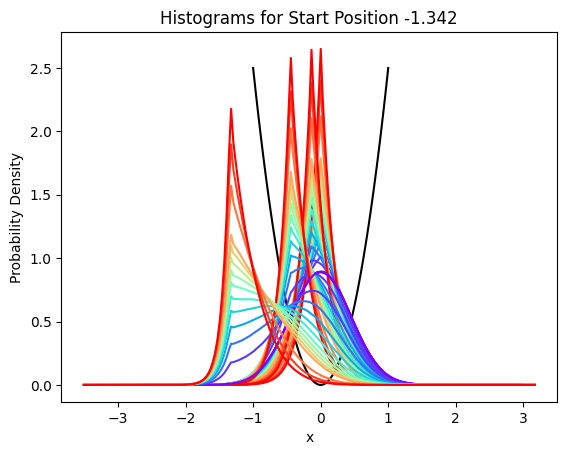

In [11]:
### plot histograms per rate per start ###
plt.plot(potential_x_unnormalized, potential_y_unnormalized, label='Harmonic Potential', color='black')
for i, histograms_per_rate in enumerate(histograms_per_rate_per_start):
    for j, (hists_per_time, c) in enumerate(zip(histograms_per_rate, resetting_colors)):
        histogram, bin_centers = hists_per_time[-1] ## ss distribution
        plt.plot(bin_centers, histogram, label=f'Start {i+1}, Rate {j+1}', color=c)
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title(f'Histograms for Start Position {start_positions[i]:.3f}')
plt.show()

In [12]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [13]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates),vmax=max(resetting_rates))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

colors_resetting = [cpick.to_rgba(rate) for rate in resetting_rates]

#####  NO Batches Analysis Of KLD relaxation 


In [55]:
###  NO Batches Analysis Of KLD relaxation ###
#raise KeyboardInterrupt

KLDs_per_rate_per_start = []

for histograms_per_rate in histograms_per_rate_per_start:
    KLDs_per_rate = []
    for histograms_per_time, resetting_rate in zip(histograms_per_rate, resetting_rates):
        KLDs_by_time_per_rate = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_time_per_rate.append(kld)
            
        KLDs_by_time_per_rate = np.array(KLDs_by_time_per_rate)
        nans, x = nan_helper(KLDs_by_time_per_rate)
        if np.sum(nans) != 0:
            KLDs_by_time_per_rate[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_time_per_rate)[~nans])
        KLDs_per_rate.append(KLDs_by_time_per_rate)
    KLDs_per_rate = np.array(KLDs_per_rate)
    KLDs_per_rate_per_start.append(KLDs_per_rate)
KLDs_per_rate_per_start = np.array(KLDs_per_rate_per_start)
np.save(folder+'/KLDs_per_rate_per_start.npy', KLDs_per_rate_per_start)

In [16]:
KLDs_per_rate_per_start = np.load(folder + '/KLDs_per_rate_per_start.npy', allow_pickle=True)

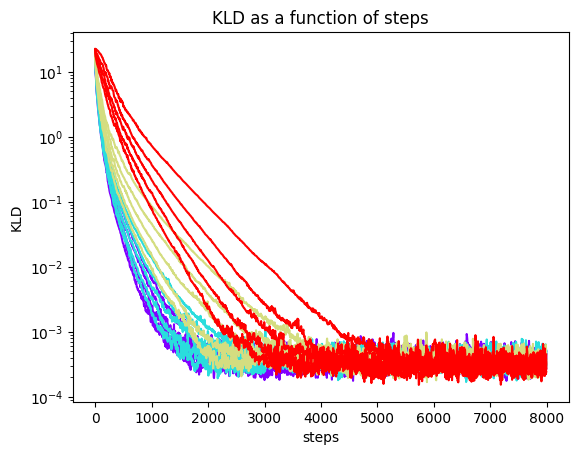

In [17]:
### plot KLDs ###

colors_starting = cm.rainbow(np.linspace(0, 1, len(start_positions)))

timesteps = np.arange(0, steady_state, 5)
for i, (KLDs_per_rate, c_start) in enumerate(zip(KLDs_per_rate_per_start, colors_starting)):
    for j, (kld_per_time, r, c) in enumerate(zip(KLDs_per_rate, resetting_rates, colors_resetting)):
        plt.semilogy(timesteps,kld_per_time, label=f'{r:.3f}', color=c_start)
        if j == 4:
            break
    plt.xlabel('steps')
    plt.ylabel('KLD')
    plt.title('KLD as a function of steps')
plt.show()

In [18]:
kld_thresholds_per_start = []
for KLDs_per_rate in KLDs_per_rate_per_start:
    kld_thresholds = []
    for kld_per_time in KLDs_per_rate:
        kld_threshold = np.min(kld_per_time[-50:])
        kld_threshold_std = np.std(kld_per_time[-50:])
        kld_threshold = kld_threshold + 10*kld_threshold_std
        kld_thresholds.append(kld_threshold)
    kld_threshold = max(kld_thresholds)
    kld_thresholds_per_start.append(kld_threshold)
kld_thresholds_per_start = np.array(kld_thresholds_per_start)
print('KLD Thresholds per start position:', kld_thresholds_per_start)

KLD Thresholds per start position: [0.00149733 0.0013421  0.00133424 0.00127623]


In [19]:
platue_index_per_r_per_start = []
for KLDs_per_rate, kld_threshold in zip(KLDs_per_rate_per_start, kld_thresholds_per_start):
    platue_index_per_r = []
    for kld_per_time, r, c in zip(KLDs_per_rate, resetting_rates, colors):
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]*dt
        platue_index_per_r.append(timestep_platue)
    platue_index_per_r = np.array(platue_index_per_r)
    platue_index_per_r_per_start.append(platue_index_per_r)
platue_index_per_r_per_start = np.array(platue_index_per_r_per_start)
np.save(folder+'/platue_index_per_r_per_start.npy', platue_index_per_r_per_start)

In [27]:
##### patching 
raise KeyboardInterrupt
sherf_num_patch = np.array([0, 39])
resetting_rate_patch = sherf_num_patch * k_harm / gamma
resetting_rates_patch_str = [f'{rate:.2f}'[1:] for rate in resetting_rate_patch]
resetting_rates_patch_str = ','.join(resetting_rates_patch_str)
print('Resetting Rates for Patch:', resetting_rates_patch_str)
start_position_str = [f'{pos:.3f}'[1:] for pos in start_positions]
patch_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_patch_str}_X-{start_positions_str}'
if k_harm != 5:
    patch_folder += f'_k={k_harm}'
patch_subfolders = [patch_folder + f'/X-{start_position:.3f}' for start_position in start_positions]
print('Folder -', patch_folder)
print('Subfolders -', patch_subfolders)


platue_index_per_r_per_start_patch = np.load(patch_folder+'/platue_index_per_r_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start = platue_index_per_r_per_start_patch[:,0]
final_platue_index_per_start = platue_index_per_r_per_start_patch[:, -1]
print('Boltzmann Platue Index per start position:', boltzmann_platue_index_per_start)
print('Final Platue Index per start position:', final_platue_index_per_start)

KeyboardInterrupt: 

##### plotting relaxation ratio as func of S 

<>:79: SyntaxWarning: invalid escape sequence '\s'
<>:79: SyntaxWarning: invalid escape sequence '\s'
C:\Users\nir19\AppData\Local\Temp\ipykernel_4108\2882927816.py:79: SyntaxWarning: invalid escape sequence '\s'
  start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'$X_R$ {abs(start_position)/typical_length_scale:.1f} $\sigma$') for c, start_position in zip(colors_starting, start_positions)]


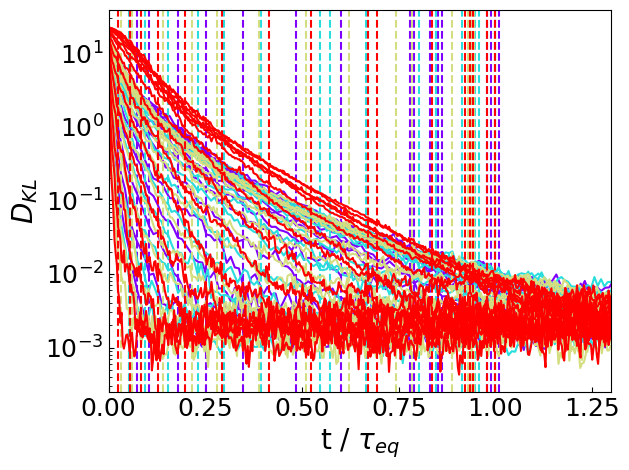

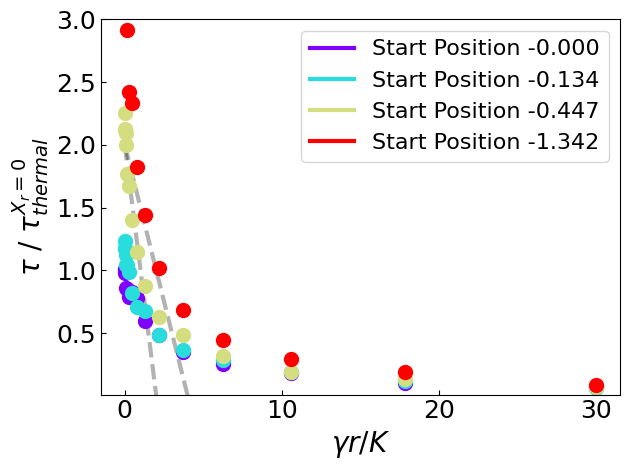

C:\Users\nir19\AppData\Local\Temp\ipykernel_4108\2882927816.py:46: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(sherf_nums, 30*sherf_nums**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
C:\Users\nir19\AppData\Local\Temp\ipykernel_4108\2882927816.py:47: RuntimeWarning: divide by zero encountered in power
  plt.plot(sherf_nums, 30*sherf_nums**slope_2, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_2}')


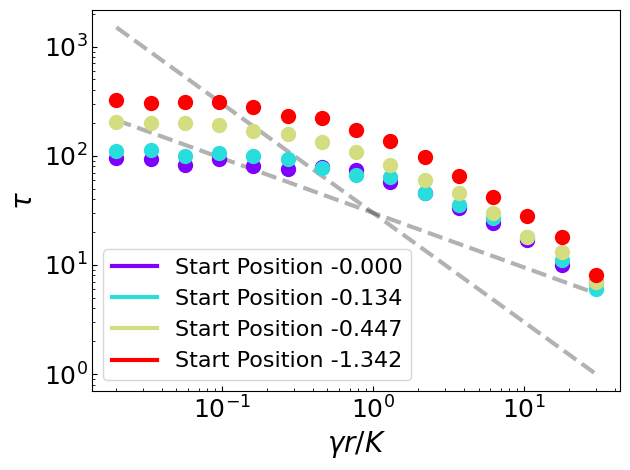

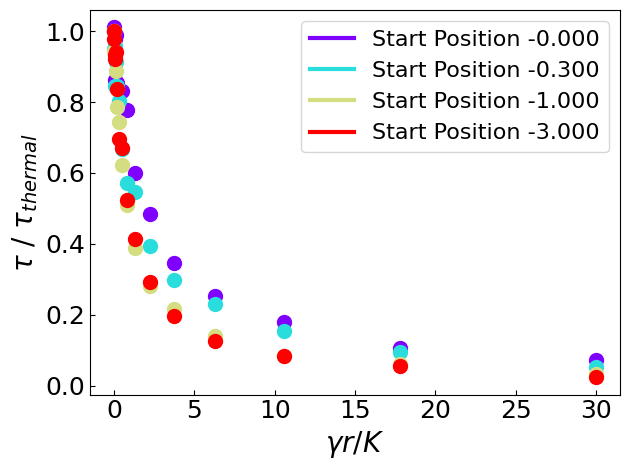

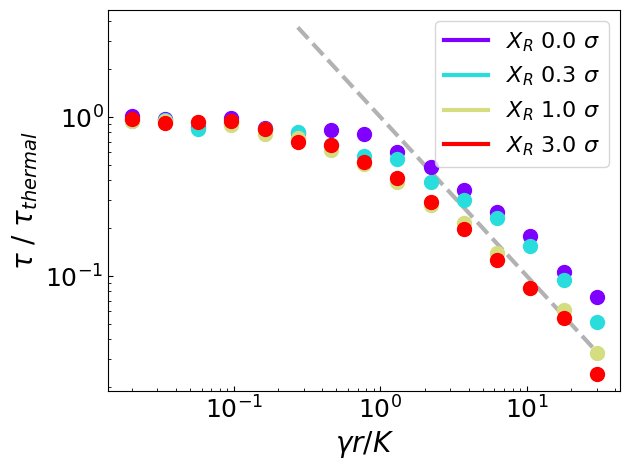

In [37]:
fig, ax = plt.subplots()

slope_1 = -1
slope_2 = -0.5

platue_index_per_r_per_start = np.load(folder+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start = np.load(folder+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start = platue_index_per_r_per_start[:,0]

for i, (KLDs_per_rate, platue_index_per_r, c_start) in enumerate(zip(KLDs_per_rate_per_start, platue_index_per_r_per_start, colors_starting)):
    for kld_per_time, platue, r, c in zip(KLDs_per_rate, platue_index_per_r, resetting_rates, colors):
        adjusted_timesteps = timesteps*dt/platue_index_per_r[0]
        adjusted_platue = platue/platue_index_per_r[0]
        im=ax.semilogy(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=c_start)
        im=ax.axvline(adjusted_platue, color=c_start, linestyle='--')
ax.set_xlabel('t / $\\tau_{eq}$', fontsize=20)
ax.set_ylabel('$D_{KL}$',fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
ax.set_xlim(0, 1.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
for i, (platue_index_per_r, c_start) in enumerate(zip(platue_index_per_r_per_start, colors_starting)):
    for i, r in enumerate(resetting_rates):
        plt.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r_per_start[0][0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]
plt.plot(sherf_nums, 2+slope_1*sherf_nums, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
plt.plot(sherf_nums, 2+slope_2*sherf_nums, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_2}')
plt.legend(handles=start_position_handles, loc='best', fontsize=16)
plt.xlabel('$\\gamma r/K$', fontsize=20)
plt.ylabel('$\\tau$ / $\\tau_{thermal}^{X_r=0}$', fontsize=20)
plt.ylim(0.01, 3)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
for i, (platue_index_per_r, c_start) in enumerate(zip(platue_index_per_r_per_start, colors_starting)):
    for i, r in enumerate(resetting_rates):
        plt.errorbar(sherf_nums[i], platue_index_per_r[i], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position:.3f}') for c, start_position in zip(colors_starting, start_positions)]
plt.plot(sherf_nums, 30*sherf_nums**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
plt.plot(sherf_nums, 30*sherf_nums**slope_2, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_2}')
plt.legend(handles=start_position_handles, loc='best', fontsize=16)
plt.xlabel('$\\gamma r/K$', fontsize=20)
plt.ylabel('$\\tau$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
for i, (platue_index_per_r, c_start, start_position) in enumerate(zip(platue_index_per_r_per_start, colors_starting, start_positions)):
    for i, r in enumerate(resetting_rates):
        if start_position == 0:
            plt.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
        else:
            plt.errorbar(sherf_nums[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Start Position {start_position/typical_length_scale:.3f}') for c, start_position in zip(colors_starting, start_positions)]
plt.legend(handles=start_position_handles, loc='best', fontsize=16)
plt.xlabel('$\\gamma r/K$', fontsize=20)
plt.ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

for i, (platue_index_per_r, c_start, start_position, boltz_platue) in enumerate(zip(platue_index_per_r_per_start, colors_starting, start_positions, boltzmann_platue_index_per_start)):
    for i, r in enumerate(resetting_rates):
        plt.errorbar(sherf_nums[i], platue_index_per_r[i]/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
plt.plot(sherf_nums[-10:], sherf_nums[-10:]**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
start_position_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'$X_R$ {abs(start_position)/typical_length_scale:.1f} $\sigma$') for c, start_position in zip(colors_starting, start_positions)]
plt.legend(handles=start_position_handles, loc='best', fontsize=16)
plt.xlabel('$\\gamma r/K$', fontsize=20)
plt.ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

##### plotting relaxation ration as func of x/sigma

In [35]:
a = np.array([[1,2,3],[4,5,6]])
b = np.array([1,2,3])
print(a/b)

[[1.  1.  1. ]
 [4.  2.5 2. ]]


Boltzmann Platue Index per rate: [111. 135. 151. 198. 210. 241. 258. 267. 285. 299. 312. 317. 358. 345.]
Normalized Platue Index per start position: [0.92792793 0.64444444 0.76821192 0.65151515 0.65714286 0.62655602
 0.65116279 0.63670412 0.64210526 0.62876254 0.63782051 0.62460568
 0.60055866 0.6173913 ]


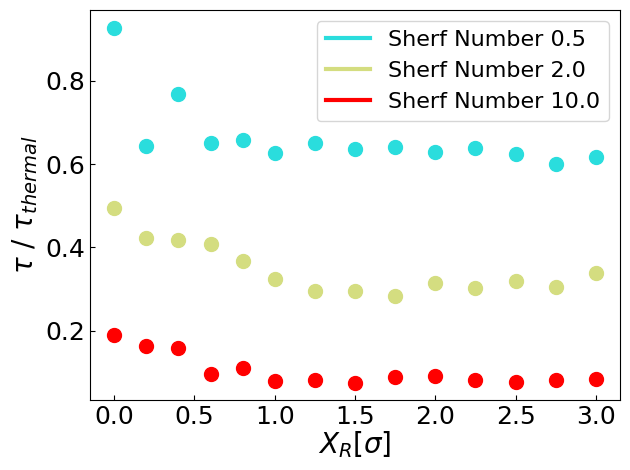

In [28]:
fig, ax = plt.subplots()

slope_1 = -1
slope_2 = -0.5

platue_index_per_r_per_start = np.load(folder+'/platue_index_per_r_per_start.npy', allow_pickle=True)
KLDs_per_rate_per_start = np.load(folder+'/KLDs_per_rate_per_start.npy', allow_pickle=True)
boltzmann_platue_index_per_start = platue_index_per_r_per_start[:,0]

platue_index_per_start_per_r = platue_index_per_r_per_start.T
KLDs_per_rate_per_start = KLDs_per_rate_per_start.T
boltz_index_per_r = platue_index_per_start_per_r[0]
print('Boltzmann Platue Index per rate:', boltz_index_per_r)
normalized_platue_index_per_start = platue_index_per_start_per_r / boltz_index_per_r
print('Normalized Platue Index per start position:', normalized_platue_index_per_start[1])
colors_sherf = cm.rainbow(np.linspace(0, 1, len(sherf_nums)))

for i, (platue_index_per_start, c_sherf, s_number) in enumerate(zip(normalized_platue_index_per_start, colors_sherf, sherf_nums)):
    if i == 0:
        continue
    for j, s in enumerate(start_positions):
        normalized_start = abs(s) / typical_length_scale
        plt.errorbar(normalized_start, platue_index_per_start[j], linestyle='--', marker = 'o', lw=3, ms=10, color=c_sherf)
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
sherf_num_handles = [plt.Line2D([0], [0], color=c, lw=3, label=f'Sherf Number {s_number:.1f}') for c, s_number in zip(colors_sherf[1:], sherf_nums[1:])]
plt.legend(handles=sherf_num_handles, loc='best', fontsize=16)
plt.xlabel('$X_R [\\sigma]$', fontsize=20, labelpad=0)
plt.ylabel('$\\tau$ / $\\tau_{thermal}$', fontsize=20)
#plt.xscale('log')
#plt.yscale('log')
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

##### Batched Analysis of the KLD relaxation

In [8]:
total_batches = 0
for filename in os.listdir(folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        total_batches += 1
print('Total Batches: ', total_batches)

Total Batches:  30


In [103]:
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 10)
histograms_per_start_pos = []
bin_edges = np.histogram_bin_edges(trajectories_per_rate[-1][-samples:], bins=201)
bins = bin_edges*2

In [ ]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
histograms_per_BRT = [] #Batch Start Time
samples = 5
target_distribution_samples = 500
steady_state = 7000
timesteps = np.arange(0, steady_state, 5)

folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}' 
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
for i in tqdm(range(total_batches)):
    histograms_per_RT = []
    for filename in os.listdir(folder):
        check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        if check_if_batch_file and batch_found == str(i+1):
            trajectories = np.load(folder+'/'+filename)
            trajectories_per_r = np.array(trajectories)
            del trajectories
            break
    histograms_per_RT = generate_histograms_per_rate(trajectories_per_r, bins, timesteps, samples, target_distribution_samples)
    del trajectories_per_r
    histograms_per_BRT.append(histograms_per_RT)
    print(f'Finished batch {i+1} of {total_batches}')
histograms_per_BRT = np.array(histograms_per_BRT)
np.save(folder+'/histograms_per_BRT.npy', histograms_per_BRT)

  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
histograms_per_BRT = np.load(folder+'/histograms_per_BRT.npy')

In [119]:
### Calculate KLDs per rate ###
#raise KeyboardInterrupt
KLDs_per_BR = []
for i, histograms_per_RT in tqdm(enumerate(histograms_per_BRT)):
    KLDs_per_R = []
    for histograms_per_time, resetting_rate in zip(histograms_per_RT, resetting_rates):
        KLDs_by_TR = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        '''
        if resetting_rate == 0:
            pdf_values = histograms_per_time[-1][0] + eps
        else:
            pdf = lambda x: pdf_resetting_in_harmonic_potential(x, *harmonic_pdf_args)
            pdf_values = pdf(bin_centers) + eps
        '''
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_TR.append(kld)
        


        KLDs_by_TR = np.array(KLDs_by_TR)
        nans, x = nan_helper(KLDs_by_TR)
        if np.sum(nans) != 0:
            KLDs_by_TR[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TR)[~nans])
        KLDs_per_R.append(KLDs_by_TR)
    KLDs_per_R = np.array(KLDs_per_R)
    KLDs_per_BR.append(KLDs_per_R)
KLDs_per_BR = np.array(KLDs_per_BR)
KLDs_per_rate_per_batch = KLDs_per_BR
np.save(folder+f'/KLDs_per_BR.npy', KLDs_per_BR)

0it [00:00, ?it/s]

In [9]:
samples = 5
target_distribution_samples = 500
steady_state = 7000
KLDs_per_rate_per_batch = np.load(folder+f'/KLDs_per_BR.npy')
timesteps = np.arange(0, steady_state, 5)

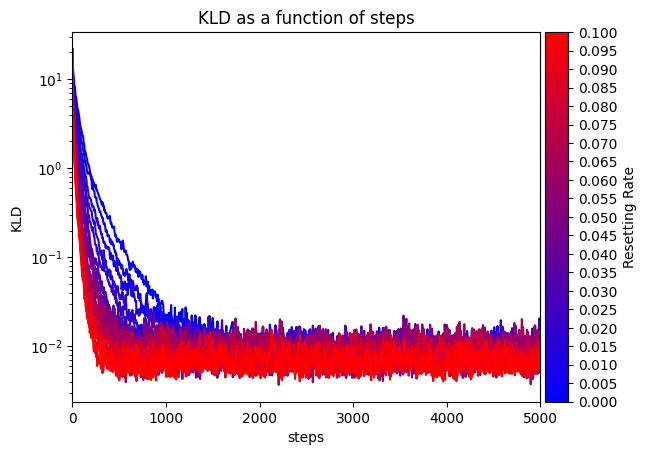

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
KLDs_per_rate = np.mean(KLDs_per_rate_per_batch, axis=0)
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

for kld_per_time, r, c in zip(KLDs_per_rate, resetting_rates, colors):
    im = ax.semilogy(timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r))
fig.colorbar(cpick, cax=cax, label='Resetting Rate', ticks=resetting_rates)
ax.set_xlabel('steps')
ax.set_ylabel('KLD')
ax.set_title('KLD as a function of steps')
ax.set_xlim(0, 5000)
plt.show()

KLD threshold: 0.05626767128503858
KLD threshold: 0.05155607178417973
KLD threshold: 0.055619117991872705
KLD threshold: 0.04552333569944806
KLD threshold: 0.0572690032044097
KLD threshold: 0.04582386780046259
KLD threshold: 0.038360592468626706
KLD threshold: 0.03651976313400169
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606
KLD threshold: 0.041768269369293606

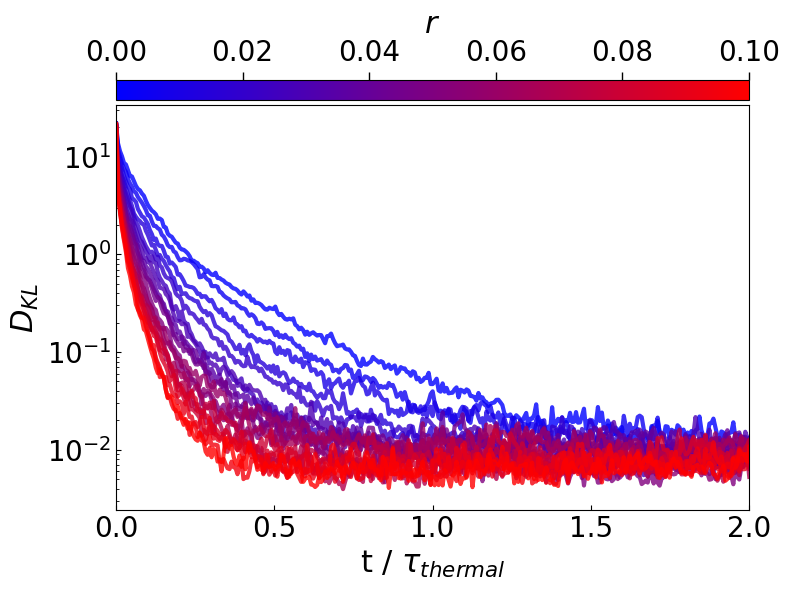

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)

platue_indices_per_r = []
for klds_per_batch in KLDs_per_rate_per_batch:
    platue_index_per_r = []
    kld_thresholds = []
    for kld_per_time in klds_per_batch:
        kld_threshold = np.mean(kld_per_time[-100:])
        kld_threshold_std = np.std(kld_per_time[-100:])
        kld_threshold = kld_threshold + 10*kld_threshold_std
        kld_thresholds.append(kld_threshold)
    kld_threshold = np.max(kld_thresholds)
    print('KLD threshold:', kld_threshold)
    for kld_per_time, r, c in zip(klds_per_batch, resetting_rates, colors):
        '''
        kld_threshold = np.mean(kld_per_time[-50:])
        kld_threshold_std = np.std(kld_per_time[-50:])
        kld_threshold = kld_threshold + 3*kld_threshold_std
        '''
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]*dt
        adjusted_platue = timestep_platue/typical_relaxation_time
        platue_index_per_r.append(adjusted_platue)
    platue_indices_per_r.append(platue_index_per_r)
platue_indices_per_r = np.array(platue_indices_per_r)
mean_platue_indices_per_r = np.mean(platue_indices_per_r, axis=0)
std_platue_indices_per_r = np.std(platue_indices_per_r, axis=0)
for kld_per_time, platue, r, c in zip(KLDs_per_rate, mean_platue_indices_per_r, resetting_rates, colors):
    adjusted_timesteps = timesteps*dt/typical_relaxation_time
    adjusted_timesteps = adjusted_timesteps/mean_platue_indices_per_r[0]
    adjusted_platue = platue/mean_platue_indices_per_r[0]
    im=ax.plot(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r), lw=3, alpha=0.8)
    #im=ax.axvline(adjusted_platue, color=cpick.to_rgba(r), linestyle='--')
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$r$', fontsize=22)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for r, c in zip(resetting_rates, colors):
    h = plt.bar([0],[0],color=cpick.to_rgba(r),label=f'r={r:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{thermal}$', fontsize=22)
ax.set_ylabel('$D_{KL}$',fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlim(0, 2)
ax.set_yscale('log')
plt.tight_layout()
figname = 'b - KLD by steps - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure1',figname)
plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

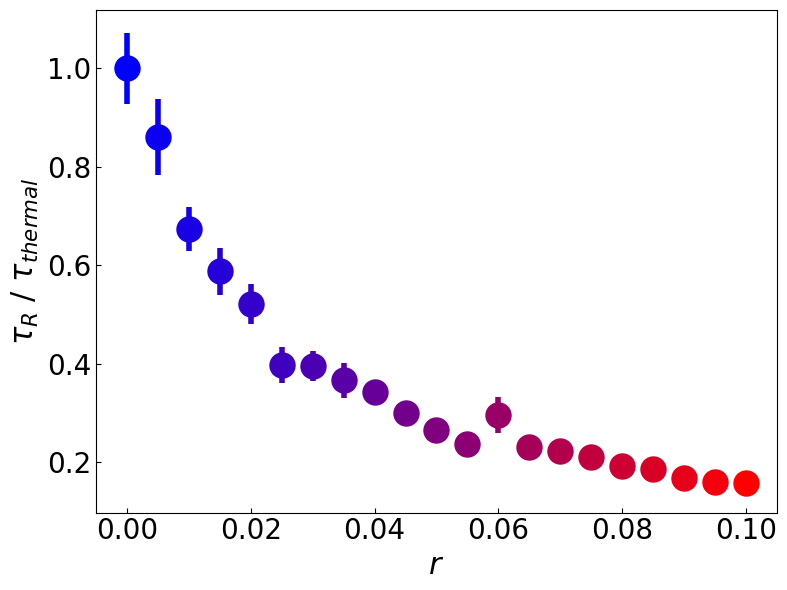

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
for i, r in enumerate(resetting_rates):
    yerr = np.sqrt((std_platue_indices_per_r[i]/mean_platue_indices_per_r[0])**2 + ((mean_platue_indices_per_r[i]*std_platue_indices_per_r[0])/(mean_platue_indices_per_r[0]**2))**2)
    ax.errorbar(resetting_rates[i], mean_platue_indices_per_r[i]/mean_platue_indices_per_r[0], yerr=yerr, linestyle='--', marker = 'o', lw=4, ms=18, color=colors_resetting[i])
ax.set_xlabel('$r$', fontsize=22)
ax.set_ylabel('$\\tau_R$ / $\\tau_{thermal}$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure1',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
plt.show()

In [ ]:
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_X-{start_positions_str}' 
subfolders = [folder + f'/X-{start_position:.3f}' for start_position in start_positions]
np.save(folder+f'/mean_platue_indices_per_r.npy', mean_platue_indices_per_r)
np.save(folder+f'/std_platue_indices_per_r.npy', std_platue_indices_per_r)
np.save(folder+f'/resetting_rates.npy', np.array(resetting_rates))

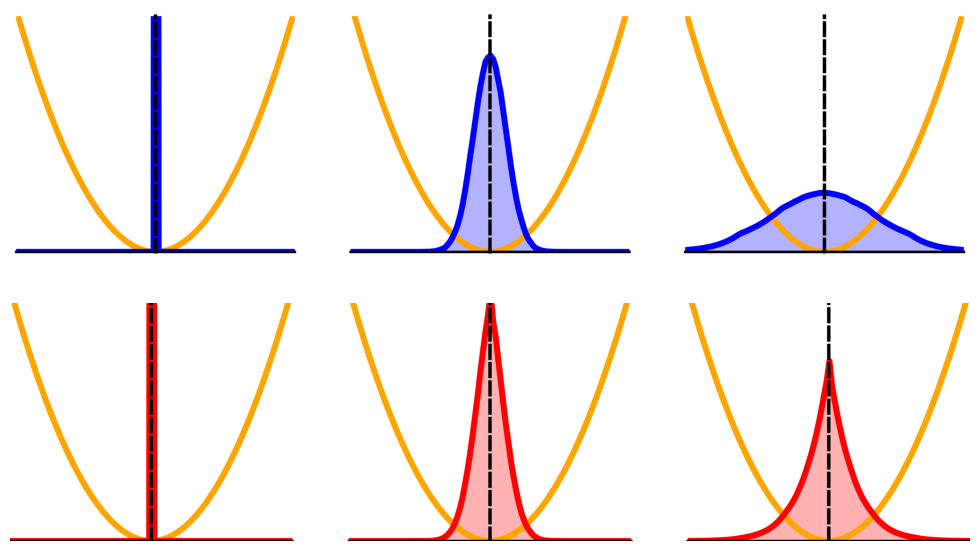

In [11]:
### Arange figure ###
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.axes import Axes
from matplotlib import patches

# Directory containing PNG files
image_dir = os.path.join('..', 'FasterByResetting-Figures/Figure1')

# Get list of PNG files
png_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

# Sort files if necessary
png_files.sort()

fig, axes = plt.subplot_mosaic("A;B", figsize=(10,6), height_ratios=[1.07,1])


img = mpimg.imread(os.path.join(image_dir, png_files[0]))
axes['A'].imshow(img)
axes['A'].axis('off')

img = mpimg.imread(os.path.join(image_dir, png_files[1]))
axes['B'].imshow(img)
axes['B'].axis('off')

fig.tight_layout()
fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)
fig.subplots_adjust(wspace=0, hspace=0)
filename = 'Figure1_option4_SS_shape.png'
plt.savefig(os.path.join('..', 'FasterByResetting-Figures', filename), bbox_inches='tight',format='png', dpi=100)
plt.show()



## Spatial Exploration (relaxation time vs. SS variance)

In [36]:
vars = np.load(folder+'/var_trajectories.npy')

In [37]:
SS_var_by_rate_resetting = []
target_distribution_samples = 500
for vars_per_rate in vars:
    SS_var_resetting = np.mean(vars_per_rate[-target_distribution_samples:])
    std_SS_var_resetting = np.std(vars_per_rate[-target_distribution_samples:])
    SS_var_by_rate_resetting.append([SS_var_resetting, std_SS_var_resetting])
SS_var_by_rate_resetting = np.array(SS_var_by_rate_resetting)

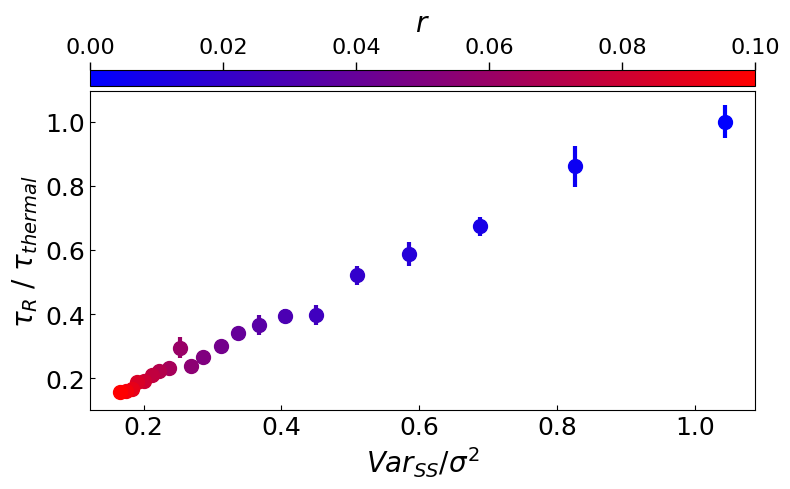

In [38]:
### Relaxation time by ss var ###
typical_length_scale = kT/k_harm
fig, ax = plt.subplots(figsize=(8, 5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)

for i in range(len(resetting_rates)):
    adjusted_platue = mean_platue_indices_per_r[i]/mean_platue_indices_per_r[0]
    yerr = std_platue_indices_per_r[i]/mean_platue_indices_per_r[0]
    ax.errorbar(SS_var_by_rate_resetting[i,0]/typical_length_scale, adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_resetting[i,1], linestyle="", marker = 'o', lw=3, ms=10, color=colors_resetting[i])
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=16, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$r$', fontsize=20)
ax.set_ylabel('$r$', fontsize=20)
ax.set_xlabel('$Var_{SS}/\\sigma^2$', fontsize=20)
ax.set_ylabel('$\\tau_R$ / $\\tau_{thermal}$', fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
fig.tight_layout()
figname = 'Relaxation time by ss var - Harmonic - Vary rate.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
plt.show()

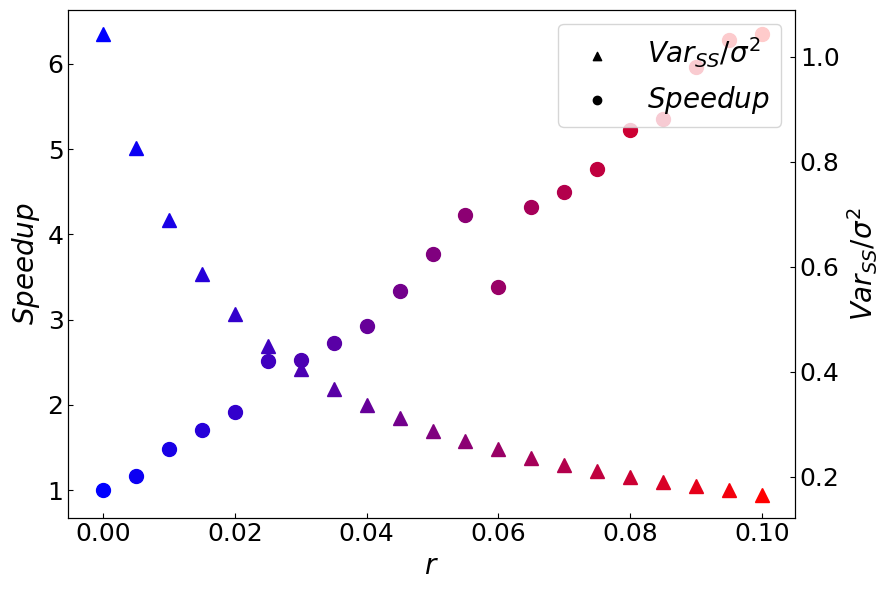

In [39]:

fig, ax1 = plt.subplots(figsize=(9, 6))
ax2 = ax1.twinx()

for i in range(len(resetting_rates)):
    adjusted_platue = mean_platue_indices_per_r[0]/mean_platue_indices_per_r[i]
    yerr = std_platue_indices_per_r[i]/mean_platue_indices_per_r[0]
    ax1.errorbar(resetting_rates[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_resetting[i,1], linestyle="", marker = 'o', lw=3, ms=10, color=colors_resetting[i])
    ax2.errorbar(resetting_rates[i], SS_var_by_rate_resetting[i, 0]/typical_length_scale, yerr=SS_var_by_rate_resetting[i, 1]/typical_length_scale, linestyle="", marker = '^', lw=3, ms=10, color=colors_resetting[i])
ax1.set_xlabel('$r$', fontsize=20)
ax1.set_ylabel('$Speedup $', fontsize=20)
ax2.set_ylabel('$Var_{SS}/\\sigma^2$', fontsize=20)
ax1.tick_params(axis='both', which='both', labelsize=18, direction='in')
ax2.tick_params(axis='both', which='both', labelsize=18, direction='in')
legned_handels = []
boltz_handle = plt.scatter([],[], marker='^', color='black', label='$Var_{SS} / \\sigma^2$')
resetting_handle = plt.scatter([],[], marker='o', color='black', label='$Speedup$')
legned_handels.append(boltz_handle)
legned_handels.append(resetting_handle)
ax2.legend(handles=legned_handels, loc='best', fontsize=20)
fig.tight_layout()
figname = 'Dual axis - Relaxation time by ss var - Harmonic - Vary rate.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=150)
plt.show()